In [1]:
import numpy as np
import pandas
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import cvxpy as cp
from mpl_toolkits.mplot3d import Axes3D
import multiprocessing 
from multiprocessing import Process, Manager
import time
import big_o


import seaborn as sns


import SynergisDataUtils
from IVutils import *


import scipy
import scipy.stats as stats
from scipy import optimize
from scipy.stats import lognorm
from scipy.stats import norm


from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import Rbf
from scipy.sparse import diags
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.interpolate import PchipInterpolator
from scipy.linalg import lstsq

from scipy import optimize
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.misc import derivative


from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score



from colorspacious import cspace_converter
from collections import OrderedDict
cmaps = OrderedDict()

from scipy.interpolate import BSpline

import pickle

plt.rcParams["figure.figsize"] = (12,6)

In [2]:
%load_ext cython

In [3]:
def measure_time(s, n=20):
    res = 0
    for k in range(n):
        start_time = time.time()
        exec(s)
        end_time = time.time()
        res += end_time-start_time
    print("time elapsed = {} s".format(res/n))

# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# Data


In [4]:
#df_load = pandas.read_csv("csvFiles/AAPLOptionsData_from=2018-05-15_to=2020-05-15.csv")
#df = df_load[["option_type", "strike", "ask", "underlying_ask", "underlying_bid"]].copy()
#df.insert(0,"quote_datetime",df_load["quote_datetime"].astype("datetime64"))
#df.insert(2,"expiration",df_load["expiration"].astype("datetime64"))
#df = df[df.quote_datetime.dt.hour==16]
#df["days_to_expiry"] = np.busday_count(df["quote_datetime"].values.astype('datetime64[D]'),
#                                       df["expiration"].values.astype('datetime64[D]'))
#df["underlying_mid"] = (df["underlying_ask"]+df["underlying_bid"])/2
#df["moneyness"] = df["strike"]/df["underlying_mid"]
#df = df.reset_index(drop=True).sort_values(["quote_datetime", "days_to_expiry", "strike"])
#
#df_stock = (df[["quote_datetime", "underlying_mid"]]
#            .drop_duplicates()
#            .sort_values(["quote_datetime"])
#            .reset_index(drop=True))
#trading_days = df.quote_datetime.drop_duplicates().sort_values().reset_index(drop=True)

In [5]:
with open('df1', 'rb') as f:
    df1 = pickle.load(f)
    
trading_days = df1.quote_datetime.drop_duplicates().sort_values().reset_index(drop=True)

df_stock = (df1[["quote_datetime", "underlying_mid"]]
            .drop_duplicates()
            .sort_values(["quote_datetime"])
            .reset_index(drop=True))

df1["index"] = df1.index

df1_array = df1.to_numpy()

# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# Functions

In [6]:
%%cython
cimport cython
from libc.math cimport  sqrt,log,exp,erf
cdef double ONE_OVER_SQRT_TWO=0.7071067811865476
from libc.stdlib cimport malloc, free
from libcpp cimport bool
from cython.parallel import prange


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cdef bint read_constraint(const double[:,:] df_cy, 
                           const long i_option_1, const long i_feature_1,
                           const long operation,
                           const long i_option_2, const long i_feature_2) nogil:
    
    cdef double value_1 = df_cy[i_option_1, i_feature_1]
    cdef double value_2 = df_cy[i_option_2, i_feature_2]
    
    
    if operation == 0:
        return value_1 == value_2
    elif operation == 1:
        return value_1 <= value_2
    elif operation == 2:
        return value_1 < value_2
    elif operation == 3:
        return value_1 >= value_2
    elif operation == 4:
        return value_1 > value_2
    elif operation == 5:
        return value_1 != value_2
    
    
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cpdef void bt_cy(long[:,:] portfolio,
                 long[:] pf_cy,
                 const double[:,:] df_cy,
                 const long[:,:] options_buckets, const long[:] lenghts_buckets,
                 long[:,:,:] constraints, const long[:,:] constraints_lengths,
                 const long index_current_bucket):
    
    """
    Let n_buckets be the number of option buckets (number of options in the options strategy)
    
    The variable constraints has a shape:
        [n_buckets] x [n_buckets] x [max(constraints_length)*3]
    
    constraints[i_1, i_2] = [f_1, o, f_2, f_1, o, f_2, ...] where:
        f1 is the feature of the option in the bucket i_1
        op is the boolean operation (">", "<", "==", etc.) 
        f2 is the feature of the option in the bucket i_2
    
    We interpret that as:
        - take o_1 an option (its index) in the bucket i_1, resp. o_2 in i_2
        - evaluate df_cy[o_1, f1] op df_cy[o_2, f22]
    
    
    operations dict:
        {"==": 0,
         "<=": 1,
         "<" : 2,
         ">=": 3,
         ">" : 4,
         "!=": 5}
    
    """
            
        
    
    cdef long length_bucket = lenghts_buckets[index_current_bucket]
    cdef int index_option_new
    
    cdef int index_const
    cdef long n_constraints
    
    cdef int index_option_pf
    
    cdef long i_option_new
    cdef long i_option_pf

    
    cdef long i_feature_new, operation, i_feature_pf
    
    cdef bint test
    
    cdef bint nothing
    
    
    cdef int i_add = 0
    cdef int i_pos_pf
    
    
    cdef bint *conditions = <bint *> malloc(length_bucket * sizeof(bint))

    
    for index_option_new in prange(length_bucket, nogil=True):
        conditions[index_option_new] = True
        i_option_new = options_buckets[index_current_bucket, index_option_new]
        
        for index_option_pf in range(index_current_bucket):
            
            i_option_pf = pf_cy[index_option_pf]
            
            n_constraints = constraints_lengths[index_current_bucket, index_option_pf]
            
            for index_const in range(n_constraints):
                
                i_feature_new = constraints[index_current_bucket, index_option_pf, index_const*3]
                operation = constraints[index_current_bucket, index_option_pf, index_const*3+1]
                i_feature_pf = constraints[index_current_bucket, index_option_pf, index_const*3+2]
                
                test = read_constraint(df_cy, i_option_new, i_feature_new, operation, i_option_pf, i_feature_pf)
                
                if not test:
                    conditions[index_option_new] = False
                    break
            if not conditions[index_option_new]:
                break
    
    
    for index_option_new in range(length_bucket):
        i_option_new = options_buckets[index_current_bucket, index_option_new]
        pf_cy[index_current_bucket] = i_option_new
        
        if conditions[index_option_new]:
            if index_current_bucket == options_buckets.shape[0]-1:
                #portfolio.append(pf_cy.copy())
                i_add = <int> portfolio[portfolio.shape[0]-1,0]
                for i_pos_pf in range(options_buckets.shape[0]):
                    portfolio[i_add,i_pos_pf] = pf_cy[i_pos_pf] 
                portfolio[portfolio.shape[0]-1,0] += 1
            else:
                bt_cy(portfolio,
                      pf_cy, df_cy, options_buckets, lenghts_buckets, 
                      constraints, constraints_lengths,
                      index_current_bucket+1)
        
    
    
                


In [14]:
%%cython
cimport cython
from libc.math cimport  ceil, floor


@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cpdef void fill_buckets(pnl_buckets,
                        const long[:,:] portfolios,
                        const long[:] df_year,
                        const long[:] df_dte,
                        const double[:] df_delta,
                        const double[:] df_ask,
                        const double[:] df_pnl):
    
    cdef long year
    
    cdef double delta_c
    cdef double delta_p
    cdef long key_call
    cdef long key_put
    cdef long key_dte
    cdef double pnl
    
    cdef int i
    cdef int N = portfolios.shape[0]
    
    for i in range(N):
        ix_c = <int>portfolios[i,0]
        ix_p = <int>portfolios[i,1]
        
        year = df_year[ix_c]
        
        delta_c = df_delta[ix_c]
        delta_p = df_delta[ix_p]
        key_call = <long> floor(delta_c*100)//3*3
        key_put = <long> ceil(delta_p*100)//3*3
                       
        key_dte = df_dte[ix_c]//5*5
        
        
        pnl = (df_pnl[ix_c] + df_pnl[ix_p])/(df_ask[ix_c] + df_ask[ix_p])
        
        pnl_buckets[(key_dte, key_call, key_put)][year].append(pnl)
        
        #pnl_buckets[i] = delta_c

In [7]:
class backtest:
    def __init__(self, df):
        self.trading_days = df.quote_datetime.drop_duplicates().sort_values().reset_index(drop=True).copy()
        self.strategy = {}
        self.contract_keys = []
        self.df = df.copy()
        self.df_day = df[df['quote_datetime']== df.at[df.index[0],'quote_datetime']]
        self.portfolios = {d:{} for d in self.trading_days}
        self.constraints = {}
        self.options_buckets = {}
        self.masks = []
        self.groups_keys = []
        

        self.portfolios_cy = []
        self.constraints_cy = []
        self.constraints_lengths = []
        self.df_cy = df.copy()
        self.pf_cy = []
        self.buckets_cy = []
        self.buckets_lengths = []
        
        self.max_length = 0
        self.features_set = set()
        self.features_map = {}
        

    def add_option(self, key, quantity, user_trading_rules=""):
        """
        :method: add a contract to the strategy
        :param key: string to identify the added contract
        :param quantity: quantity to buy or sell (positive or negative)
        :param trading_rule: string, user input in the format "strike > 4, feature operation value, …"
        :return: none
        """
        self.contract_keys.append(key)
        trading_rules = []
        if len(user_trading_rules) != 0:
            trading_rules = user_trading_rules.split(", ")
        self.strategy[key] = {
            "quantity": quantity,
            "trading_rules": trading_rules
        }
    
    def select_data(self, rules):
        """
        :method: selects data according to rules
        :param rules: list of strings, each string has the format "feature operation value"
        :return: indices of selected options in self.df/self.df_day
        """
        s = ""
        for r in rules:
            if s != "":
                s += " & "
            feature, operation, value = r.split(" ")
            if feature == "option_type":
                value = "'{}'".format(value)
            s += "(self.df_day['{}'] {} {})".format(feature, operation, value)
        return eval("self.df_day[{}].index".format(s))
    
    def initialize_constraints(self):
        """
        warning! all contracts of the strategy must have been added
        :method: create a dictionary of mutual constraints between contracts of the strategy
        """
        self.constraints = {x:{y:[] for y in self.contract_keys if y != x} for x in self.contract_keys}
        
        
        
    
    def add_constraints(self, user_constraints):
        """
        :method: add contraints between contracts of the strategy
        :param user_constraints: string in the format "key_1.feature_1 operation key_2.feature_2, …"
        :return: none
        """
        reverse_operations = {
        ">": "<",
        "==": "==",
        "<": ">",
        ">=": "<=",
        "<=": ">="
        }
        for const in user_constraints.split(", "):
            e1, o, e2 = const.split(" ")
            key1, feature1 = e1.split(".")
            key2, feature2 = e2.split(".")
            self.constraints[key1][key2].append({"feature_self": feature1, 
                                                 "operation": o, 
                                                 "feature_other": feature2})
            self.constraints[key2][key1].append({"feature_self": feature2, 
                                                 "operation": reverse_operations[o], 
                                                 "feature_other": feature1})
    
    
    def add_masks(self, user_masks):
        """
        :method: add a common condition across all contracts of the strategy
        :param user_masks: string in the format "feature operation value, …"
        """
        for mask in user_masks.split(", "):
            self.masks.append(mask)
    
    
    def add_groups(self, user_group):
        """
        :method: add a feature that has to be common across all contracts of the strategy
        :param user_masks: string in the format "feature operation value, …"
        """
        for feature in user_group.split(", "):
            self.groups_keys.append(feature)
    
    def set_day(self, day):
        """
        :method: selects the sub-dataframe that corresponds to the chosen day, filtered by masks,
                 sets the value of df_days
        """
        m = "(self.df['quote_datetime']==day)"
        for mask in self.masks:
            m += " & "
            feature, operation, value = mask.split(" ")
            if feature == "option_type":
                value = "'{}'".format(value)
            m += "(self.df['{}'] {} {})".format(feature, operation, value)
        self.df_day = eval("self.df[{}]".format(m))
    
    
    def set_buckets(self, group_key_value):
        """
        :method: sets the buckets candidates contracts, satisfying the strategy
        """
        self.options_buckets = {}
        
        rule_group = []
        for i_group, key in enumerate(self.groups_keys):
            rule_group.append("{} == {}".format(key, group_key_value[i_group]))
        
        for key in self.contract_keys:
            rules = rule_group + self.strategy[key]["trading_rules"] 
            self.options_buckets[key] = self.select_data(rules)
    
    
    def initialize_cython_parameters(self):
        for x in self.contract_keys:
            for y in self.constraints[x]:
                self.max_length = max(len(self.constraints[x][y]), self.max_length)
                
        self.pf_cy = np.zeros(len(self.contract_keys), dtype=int)
        
        operations_map = {
            "==": 0,
            "<=": 1,
            "<" : 2,
            ">=": 3,
            ">" : 4,
            "!=": 5
        }
        
        self.constraints_lengths = np.zeros((len(self.contract_keys), 
                                             len(self.contract_keys)), dtype=int)
        
        for k1 in self.contract_keys:
            for k2 in self.constraints[k1].keys():
                for x in self.constraints[k1][k2]:
                    f1 = x["feature_self"]
                    o = x["operation"]
                    f2 = x["feature_other"]
                    self.features_set.add(f1)
                    self.features_set.add(f2)
        
        for i_f, f in enumerate(list(self.features_set)):
            self.features_map[f] = i_f
        
        
        
        self.constraints_cy = np.zeros((len(self.contract_keys), 
                                        len(self.contract_keys), 
                                        self.max_length*3), dtype=int)
        
        for i_x, x in enumerate(list(self.contract_keys)):
            for i_y, y in enumerate(list(self.contract_keys)):
                if i_x != i_y:
                    self.constraints_lengths[i_x,i_y] = len(self.constraints[x][y])
                    for i_e, e in enumerate(self.constraints[x][y]):
                        f1 = e["feature_self"]
                        o = e["operation"]
                        f2 = e["feature_other"]
                        self.constraints_cy[i_x,i_y,i_e*3:i_e*3+3] = (
                            self.features_map[f1], 
                            operations_map[o], 
                            self.features_map[f2]
                        )
        
        self.portfolios_cy = np.zeros((50*10**6+1, len(self.contract_keys))).astype(int)
        
        
    def set_df_cython(self):
        self.df_cy = self.df_day[list(self.features_set)].values
        
        index_map = {e: i_e for i_e, e in enumerate(self.df_day[list(self.features_set)].index)}
        
        
        # x = [[index_map[i] for i in bucket] for bucket in self.options_buckets.values()]
        x = [[b for b in bucket] for bucket in self.options_buckets.values()]
        
        length = max(map(len, x))
        self.buckets_cy = np.array([xi+[-1]*(length-len(xi)) for xi in x], dtype=int)
        
        self.buckets_lengths = np.array([len(x) for x in self.options_buckets.values()], dtype=int)
        

    def compute_pnl(self):
        """
        :method: compute pnl of each portfolio in portfolios' dictionary
        """
        for key_day in self.portfolios.keys():
            for key_group in self.portfolios[key_day].keys():
                for i_pf, pf in enumerate(self.portfolios[key_day][key_group]):
                    res = 0
                    cost = 0
                    for i, i_option in enumerate(pf):
                        weight = self.strategy[self.contract_keys[i]]["quantity"]
                        res += weight * self.df.at[i_option, "PnL"]
                        cost += weight * self.df.at[i_option, "ask"]
                    self.portfolios[key_day][key_group][i_pf].append(cost)
                    self.portfolios[key_day][key_group][i_pf].append(res)
                    
    def find_entry_cy(self):
        """
        iterate trading day → filter by masks → iterate groups → filter by trading rules
            → run backtest on resulting contract buckets → save portfolios in portfolios' dictionary
        """
        for day in self.trading_days:
            #print(day)
            self.set_day(day)
            for group_key_value in (self.df_day[self.groups_keys]
                                    .drop_duplicates()
                                    .itertuples(index=False, name=None)):
                self.set_buckets(group_key_value)
                
                self.set_df_cython()
                
                bt_cy(portfolio=self.portfolios_cy,
                      pf_cy=self.pf_cy,
                      df_cy=self.df_cy,
                      options_buckets=self.buckets_cy, 
                      lenghts_buckets=self.buckets_lengths,
                      constraints=self.constraints_cy, 
                      constraints_lengths=self.constraints_lengths,
                      index_current_bucket=0)
                     
            
    
    def compute_pnl(self):
        """
        :method: compute pnl of each portfolio in portfolios' dictionary
        """
        for key_day in self.portfolios.keys():
            for key_group in self.portfolios[key_day].keys():
                for i_pf, pf in enumerate(self.portfolios[key_day][key_group]):
                    res = 0
                    cost = 0
                    for i, i_option in enumerate(pf):
                        weight = self.strategy[self.contract_keys[i]]["quantity"]
                        res += weight * self.df.at[i_option, "PnL"]
                        cost += weight * self.df.at[i_option, "ask"]
                    self.portfolios[key_day][key_group][i_pf].append(cost)
                    self.portfolios[key_day][key_group][i_pf].append(res)

In [8]:
def find_stock_expiry(day, dte):
    index_current = df_stock[df_stock["quote_datetime"]==day].index[0]
    index_exp = index_current + int(dte)
    return df_stock.at[index_exp, "underlying_mid"]

# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------
# ------ ------ ------ ------ ------ ------ ------ ------ ------ ------

# Choose the dataframe and compute PnL of each options (hold until expiry)

In [9]:
#select_year = 2013
#df1_slice = df1[df1.year==select_year].copy()

#df1_slice = df1[df1.quote_datetime==df1.iloc[707537].quote_datetime].copy()

df1_slice = df1.copy()

# Choose the option strategy

In [10]:
res = backtest(df1_slice)
res.add_option("c", 1, "option_type == C, delta > 0.15, delta < 0.45")
res.add_option("p", 1, "option_type == P, delta < -0.15, delta > -0.45")
res.initialize_constraints()
res.add_groups("days_to_expiry")
res.add_masks("days_to_expiry > 0, days_to_expiry < 80")
res.initialize_cython_parameters()

In [ ]:
#print(res.trading_days)
#print(res.strategy )
#print(res.contract_keys )
#print(res.buckets_lengths)
#print(res.portfolios)
#print(res.constraints)
#print(res.options_buckets)
#print(res.groups_keys)
#print(res.masks)
#print(res.pnl_buckets.keys())

# Run backtest

In [11]:
start_time = time.time()

res.find_entry_cy()

end_time = time.time()
print("time elapsed = {} s".format(end_time-start_time))

time elapsed = 160.82621264457703 s


In [12]:
print(res.portfolios_cy.shape)
print(res.portfolios_cy[-1,0])

portfolios = res.portfolios_cy[:res.portfolios_cy[-1,0]]
portfolios.shape

(50000001, 2)
7629436


(7629436, 2)

# Bucketing

In [13]:
pnl_buckets = {}
dte_grid = np.array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75])

delta_call_grid = np.array([15, 18, 21, 24, 27, 30, 33, 36, 39, 42])

delta_put_grid = np.array([-15, -18, -21, -24, -27, -30, -33, -36, -39, -42])

year_grid = np.array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019])

for dte in dte_grid:
    for delta_call in delta_call_grid:
        for delta_put in delta_put_grid:
            pnl_buckets[(dte, delta_call, delta_put)] = {y: [] for y in year_grid}

In [15]:
#print(df1.columns)
#print("13", df1.columns[13])
#print("7 ", df1.columns[7 ])
#print("11", df1.columns[11])
#print("4 ", df1.columns[4 ])
#print("10", df1.columns[10])

start_time = time.time()
fill_buckets(pnl_buckets,
             portfolios=portfolios,
             df_year=   df1_array[:,13].astype(int),
             df_dte=    df1_array[:,7].astype(int),
             df_delta=  df1_array[:,11].astype(float),
             df_ask=    df1_array[:,4].astype(float),
             df_pnl=    df1_array[:,10].astype(float))

stop_time = time.time()
print(stop_time - start_time)

7.487865209579468


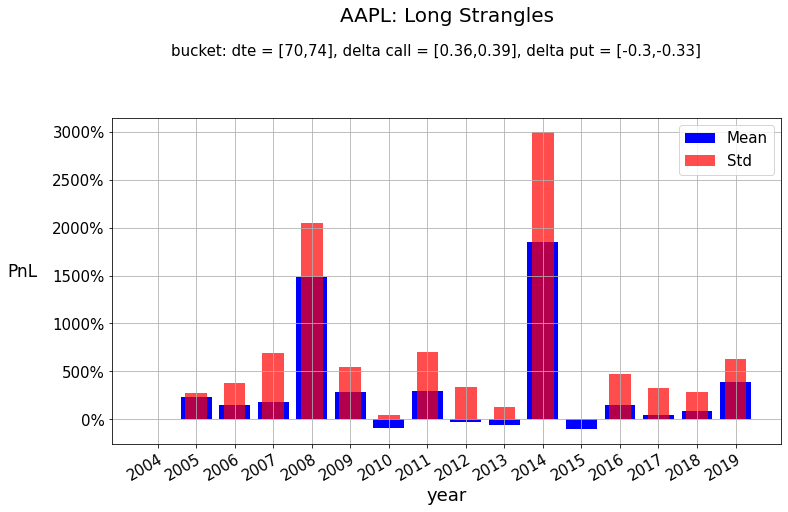

In [17]:
key_bucket = (70, 36, -30)

years = np.arange(2004,2020).astype(str)

pnl_series_mean = np.zeros(len(years))
pnl_series_std = np.zeros(len(years))

for key_year in list(pnl_buckets[key_bucket].keys()):
    if len(pnl_buckets[key_bucket][key_year]) > 0:
        pnl_series_mean[key_year-2004] = np.mean(pnl_buckets[key_bucket][key_year])
        pnl_series_std[key_year-2004] = np.std(pnl_buckets[key_bucket][key_year])

plt.title('AAPL: Long Strangles',ha='center',fontsize=20, y=1.275)
plt.suptitle("bucket: dte = [{},{}], delta call = [{},{}], delta put = [{},{}]".format(
    key_bucket[0],key_bucket[0]+4,  
    round(key_bucket[1]/100,2), round(key_bucket[1]/100+0.03,2),
    round(key_bucket[2]/100,2), round(key_bucket[2]/100-0.03,2)),ha='center',fontsize=15,y=1.05)

width=0.8
plt.bar(years, pnl_series_mean*100,
        width=width, color='b', label='Mean', capsize=10)
plt.bar(years, pnl_series_std*100, 
        width=width*0.7, color='r', alpha=0.7, label='Std', capsize=10)


plt.xticks(rotation=30, horizontalalignment='right', rotation_mode='anchor')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.xlabel("year",fontsize=18)
plt.ylabel("PnL",fontsize=17,rotation=0,labelpad=30)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid()